In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [3]:
train=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [4]:
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [5]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


In [6]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
# check for uniqueness
idsUnique = len(set(train.Id))
idsTotal = train.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

There are 0 duplicate IDs for 1460 total entries


In [8]:
# Remove the Ids from train and test, as they are unique for each row and hence not useful for the model
train_ID = train['Id']
test_ID = test['Id']
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)
train.shape, test.shape

((1460, 80), (1459, 79))

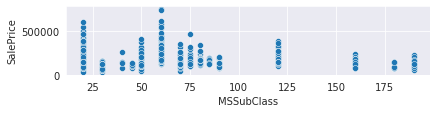

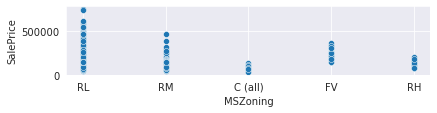

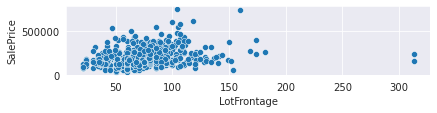

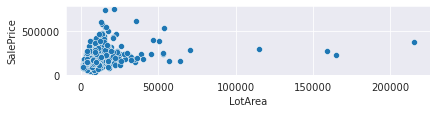

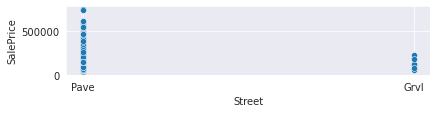

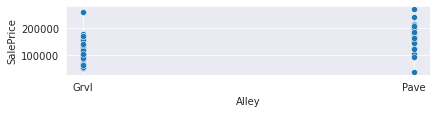

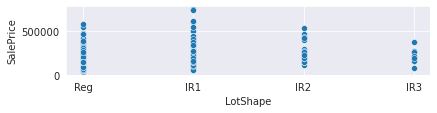

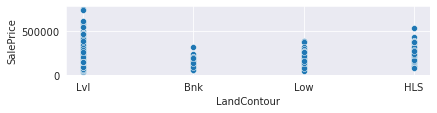

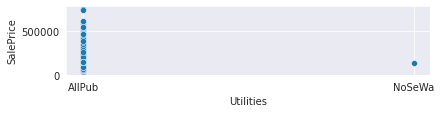

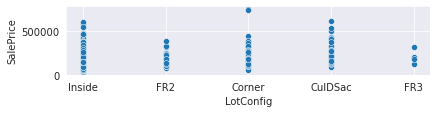

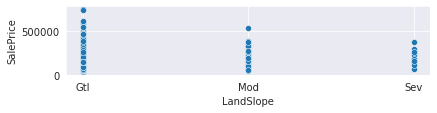

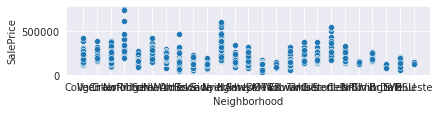

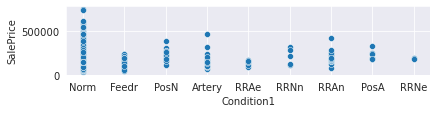

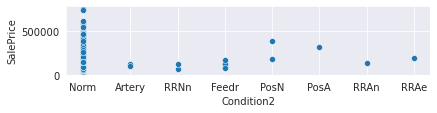

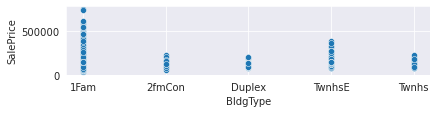

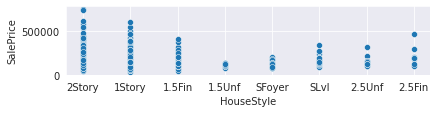

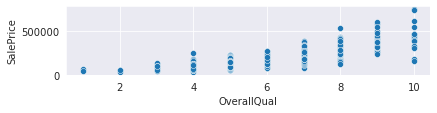

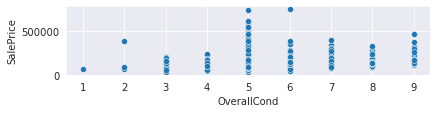

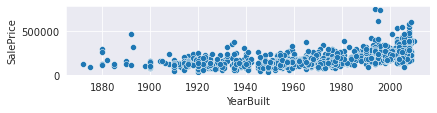

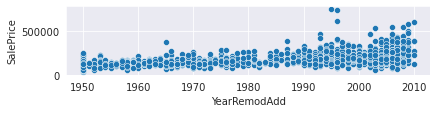

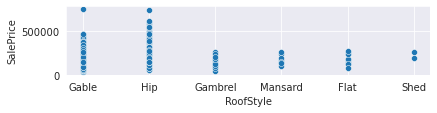

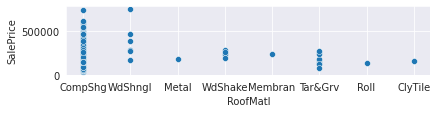

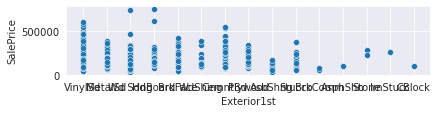

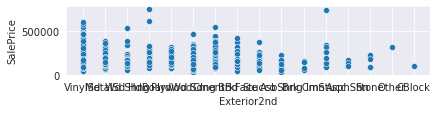

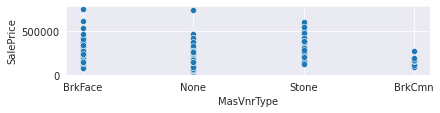

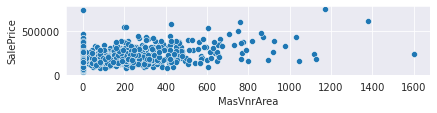

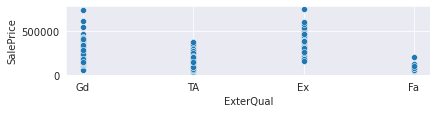

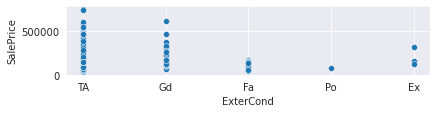

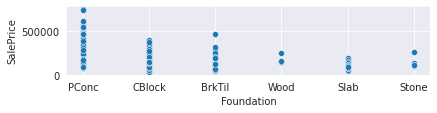

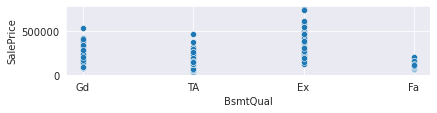

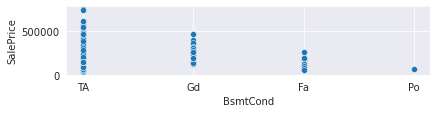

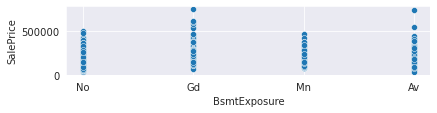

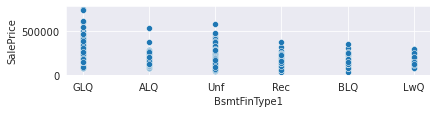

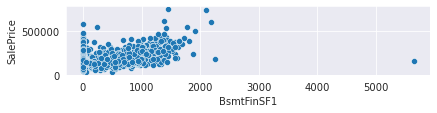

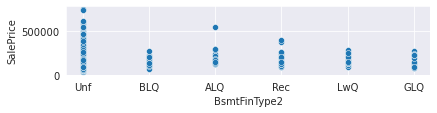

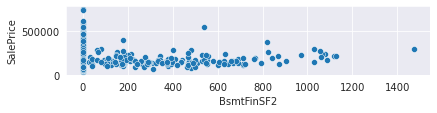

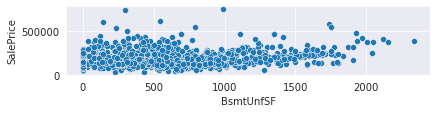

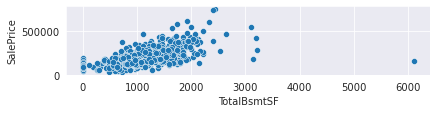

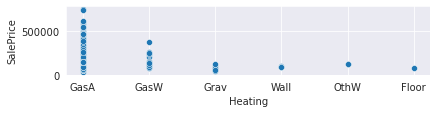

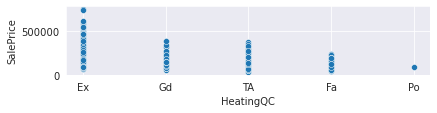

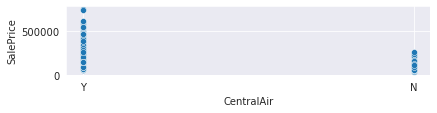

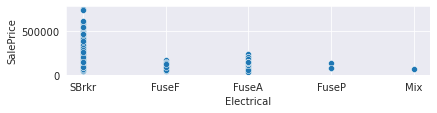

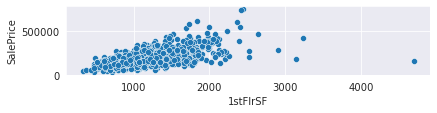

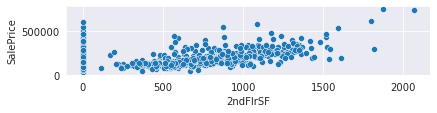

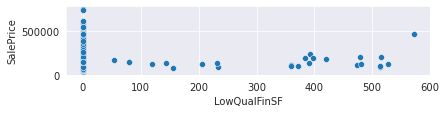

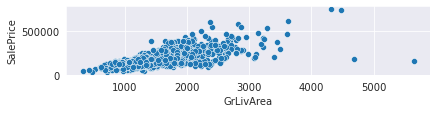

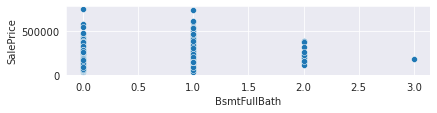

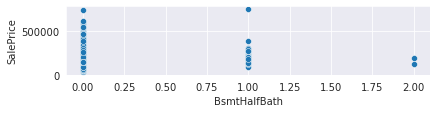

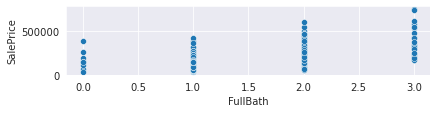

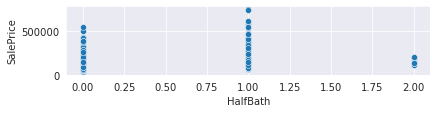

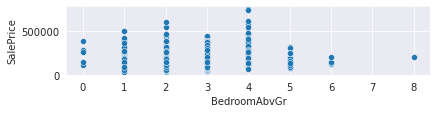

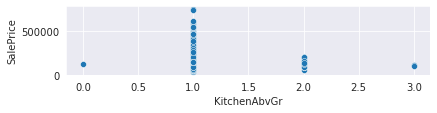

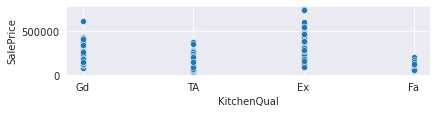

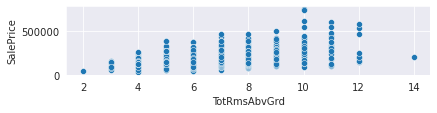

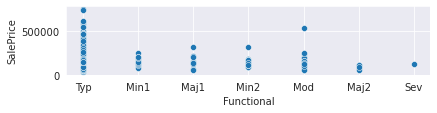

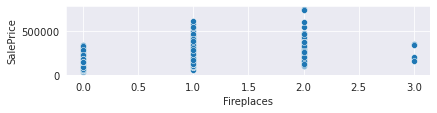

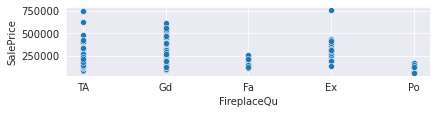

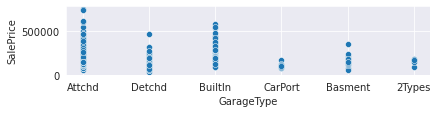

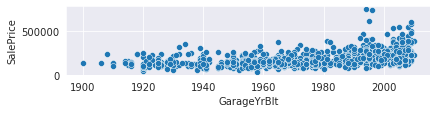

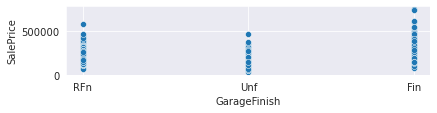

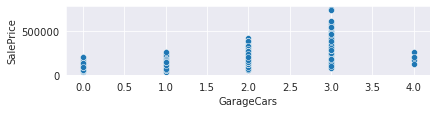

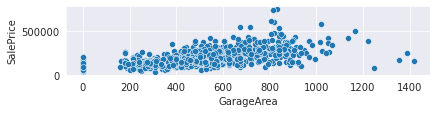

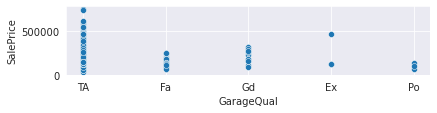

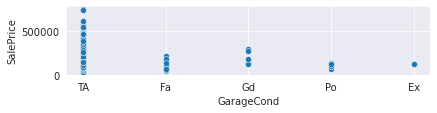

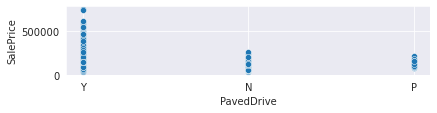

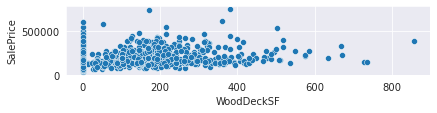

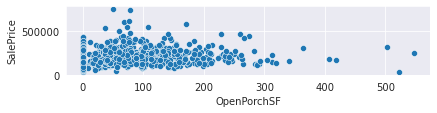

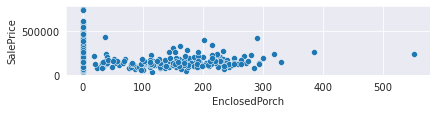

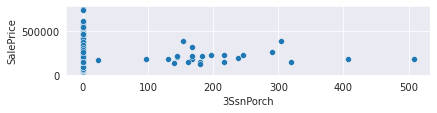

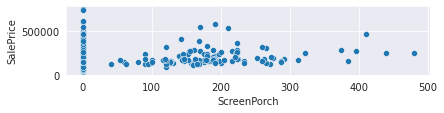

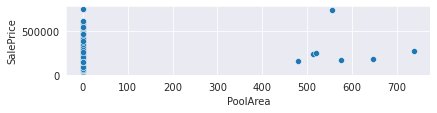

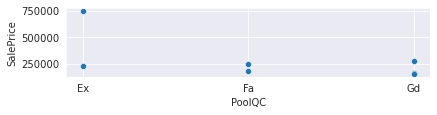

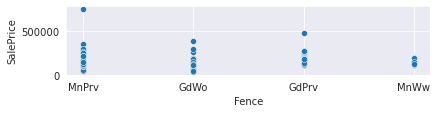

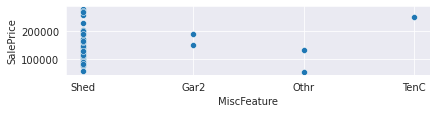

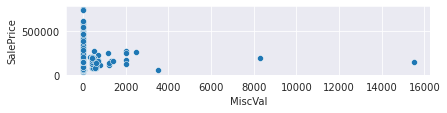

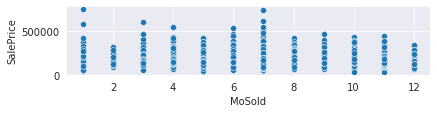

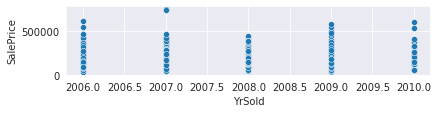

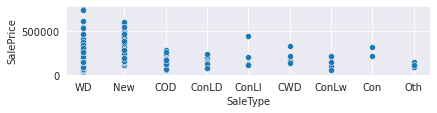

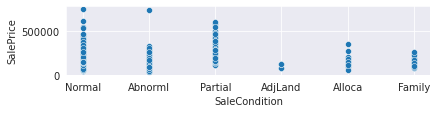

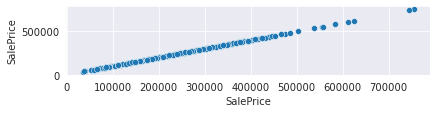

In [9]:
for i,j in enumerate(train.columns):
    plt.figure(figsize=(30,30))
    plt.subplot(20,4,i+1)
    sns.scatterplot(train[j],train['SalePrice']);

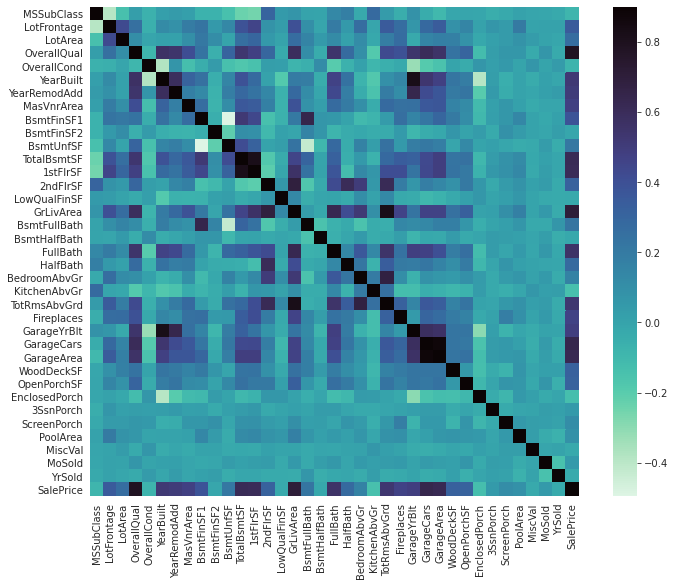

In [10]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
heatm = sns.heatmap(corrmat, vmax=0.9, square=True, cmap = 'mako_r');


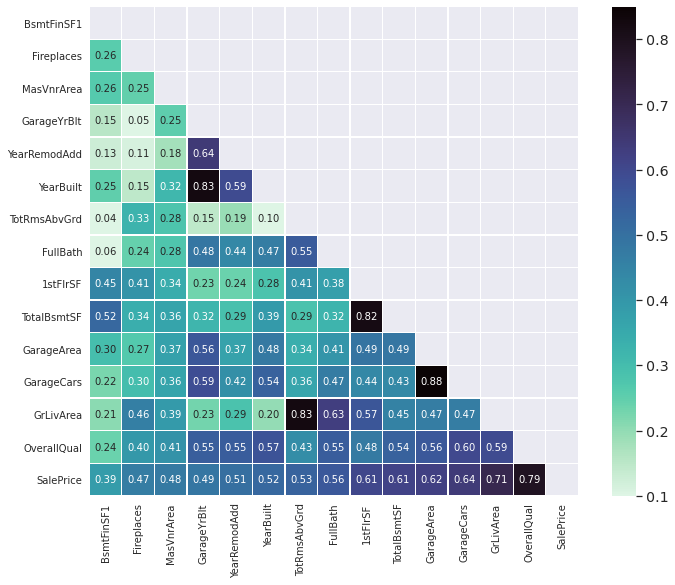

In [11]:
#saleprice correlation matrix
n = 15
#number of parameters for heatmap
cols = corrmat.nlargest(n, 'SalePrice')['SalePrice'].index
cols2 = np.array(list(reversed(cols)))
cm = train[cols2].corr()
# mask to get only the upper triangle of the matrix, as the lower one is just repeated information
mask = np.triu(np.ones_like(cm, dtype=np.bool))
# adjust mask and df

cm2 = cm.iloc[1:,:-1].copy()
f, ax = plt.subplots(figsize=(12, 9))
sns.set(font_scale=1.3)
heatmap = sns.heatmap(cm,mask=mask, cbar=True, annot=True, square=True, cmap = 'mako_r', fmt='.2f', vmin=.1, vmax=.85,linewidth=0.3, annot_kws={'size': 10}, yticklabels=cols2, xticklabels=cols2)


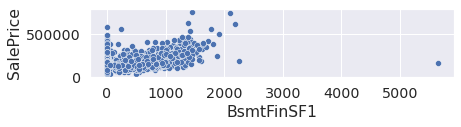

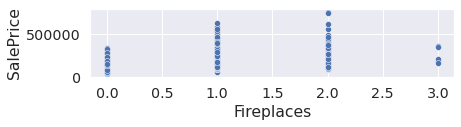

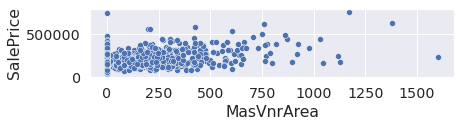

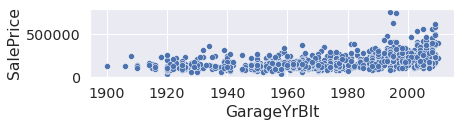

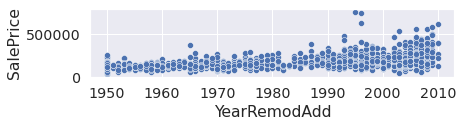

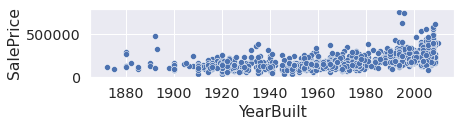

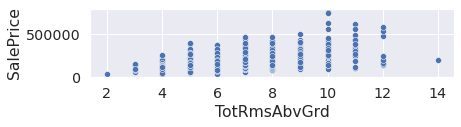

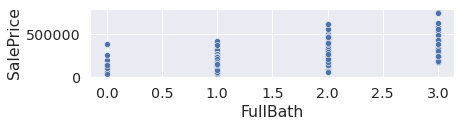

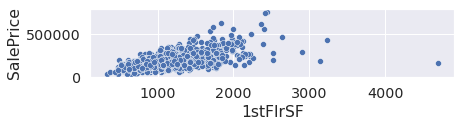

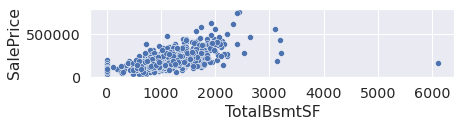

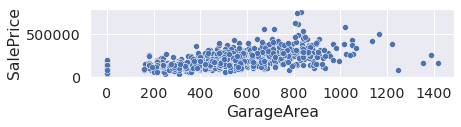

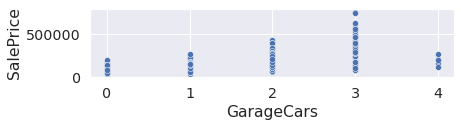

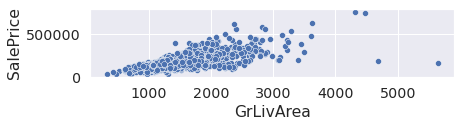

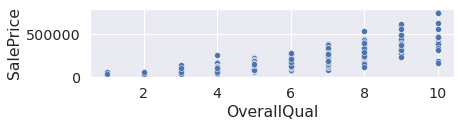

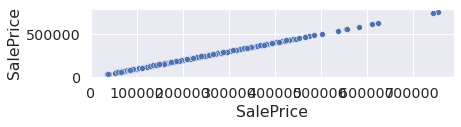

In [12]:
for i,j in enumerate(cols2):
    plt.figure(figsize=(30,30))
    plt.subplot(20,4,i+1)
    sns.scatterplot(train[j],train['SalePrice']);

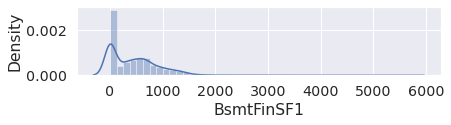

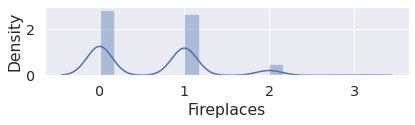

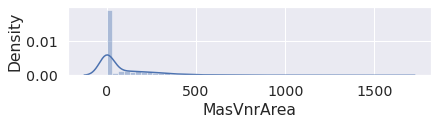

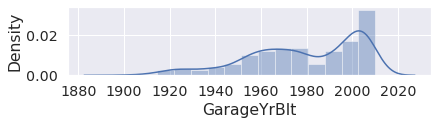

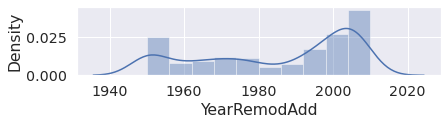

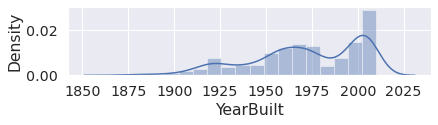

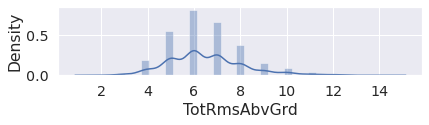

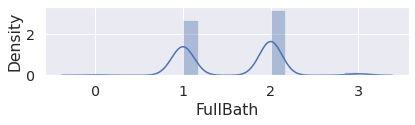

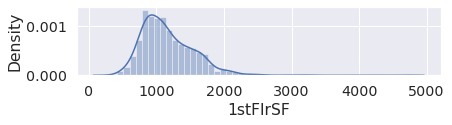

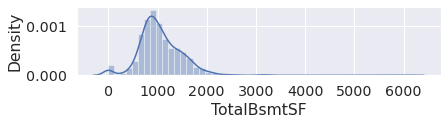

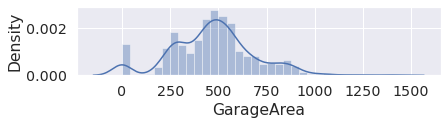

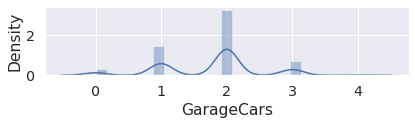

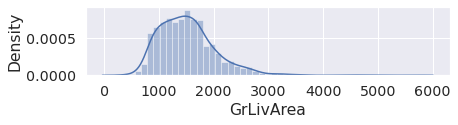

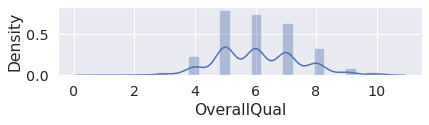

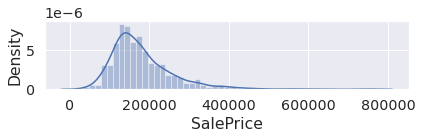

In [13]:
for i,j in enumerate(cols2):
    plt.figure(figsize=(30,30))
    plt.subplot(20,4,i+1)
    sns.distplot(train[j]);

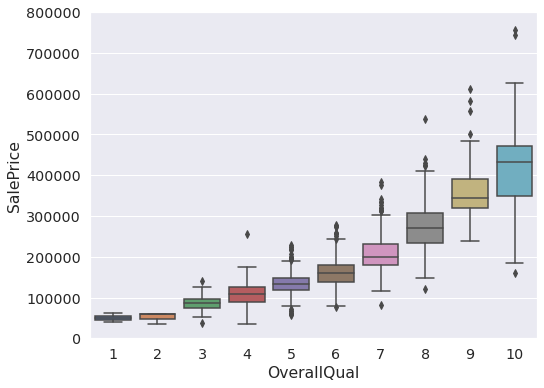

In [14]:
data = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=train['OverallQual'], y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);



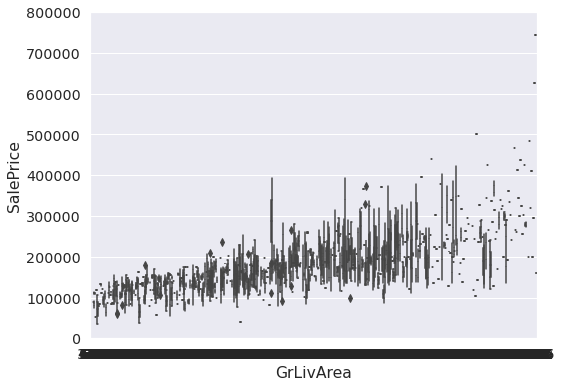

In [15]:
data = pd.concat([train['SalePrice'], train['GrLivArea']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=train['GrLivArea'], y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);



In [16]:
# Remove outliers
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True)
train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<300000)].index, inplace=True)
train.reset_index(drop=True, inplace=True)

In [17]:
# Split features and labels
y_train = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
train = pd.concat([train_features, test_features]).reset_index(drop=True)
train.shape

(2916, 79)

Text(0.5, 1.0, 'SalePrice distribution')

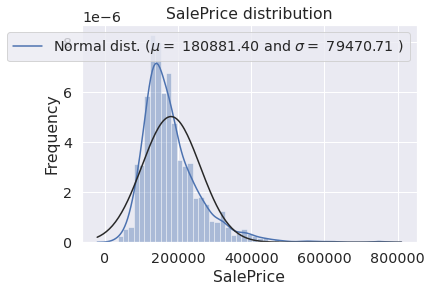

In [18]:

# we will now check SalePrice for its closeness to the normal distribution. 
sns.distplot(y_train,fit=norm);
(mu, sigma)=norm.fit(y_train)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')


Text(0.5, 1.0, 'SalePrice distribution')

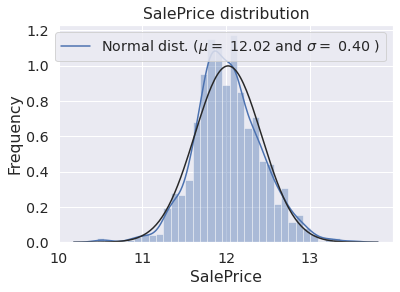

In [19]:
# We need to transform the target variable as linear models favor normlised data

# transforming Sales Price by log (1+x) transformation. This caters for 0 values in the columns
y_train=np.log1p(y_train)
# we check the distribution again after the transformation
sns.distplot(y_train,fit=norm);
(mu, sigma)=norm.fit(y_train)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

In [20]:
# we will see each column for the type of data present
for i in train.columns:
    print("the category is {} , number of features are {}, they are {}".format(i,train[i].nunique(),train[i].unique()))


the category is MSSubClass , number of features are 16, they are [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40 150]
the category is MSZoning , number of features are 5, they are ['RL' 'RM' 'C (all)' 'FV' 'RH' nan]
the category is LotFrontage , number of features are 128, they are [ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40.
 105.  73.  77.  64.  94.  34.  90.  55.  88.  82.  71. 120. 107.  92.
 134.  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.
  93.  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.
  36.  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39.
 144. 114. 128. 149. 313. 168. 182. 138. 160. 152. 124. 153.  46.  26.
  25. 119.  31.  28. 117. 113. 125. 135. 136.  22. 123. 195. 155. 126.
 200. 131. 133.]
the category is LotArea , number of features are

In [21]:
categorical=[feat for feat in train.columns if train[feat].nunique()<30]

for i in categorical:
    print("the category is {} and number of features are {}".format(i,train[i].unique()))

the category is MSSubClass and number of features are [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40 150]
the category is MSZoning and number of features are ['RL' 'RM' 'C (all)' 'FV' 'RH' nan]
the category is Street and number of features are ['Pave' 'Grvl']
the category is Alley and number of features are [nan 'Grvl' 'Pave']
the category is LotShape and number of features are ['Reg' 'IR1' 'IR2' 'IR3']
the category is LandContour and number of features are ['Lvl' 'Bnk' 'Low' 'HLS']
the category is Utilities and number of features are ['AllPub' 'NoSeWa' nan]
the category is LotConfig and number of features are ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
the category is LandSlope and number of features are ['Gtl' 'Mod' 'Sev']
the category is Neighborhood and number of features are ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 

In [22]:
#### Checking for missing values

data_na=(train.isna().sum()/len(train))*100 # creating a series that has total percentage of missing values

data_na=data_na.drop(data_na[data_na==0].index).sort_values(ascending=False) # filtering the series and sorting

data_na=pd.DataFrame({'Missing':data_na}) # creating dataframe and storing
data_na.head(30)


,Missing
PoolQC,99.691358
MiscFeature,96.399177
Alley,93.209877
Fence,80.418381
FireplaceQu,48.696845
LotFrontage,16.632373
GarageFinish,5.452675
GarageQual,5.452675
GarageCond,5.452675
GarageYrBlt,5.452675


In [23]:
# Some of the non-numeric predictors are stored as numbers; convert them into strings 
train['MSSubClass'] = train['MSSubClass'].apply(str)
train['YrSold'] = train['YrSold'].astype(str)
train['MoSold'] = train['MoSold'].astype(str)

In [24]:
for i in train[['MSSubClass','YrSold','MoSold']].columns:
    print(i, train[i].unique())

MSSubClass ['60' '20' '70' '50' '190' '45' '90' '120' '30' '85' '80' '160' '75' '180'
 '40' '150']
YrSold ['2008' '2007' '2006' '2009' '2010']
MoSold ['2' '5' '9' '12' '10' '8' '11' '4' '1' '7' '3' '6']


In [25]:
### Handling missing values

#### PoolQC:  categorical ordinal

#PoolQC : data description says NA means "No Pool".Majority of houses have no Pool at all in general. 

train['PoolQC']=train['PoolQC'].fillna('None')

#### miscellaneous: categorical nominal

# miscellaneous features: Na means None
train["MiscFeature"] = train["MiscFeature"].fillna("None")


#### alley: categorical nominal

#Alley :NA means "no alley access"
train["Alley"] = train["Alley"].fillna("None")

#### fence: categorical nominal

#NA means "no fence"
train["Fence"] = train["Fence"].fillna("None")

#### FireplaceQu: categorical ordinal

#FireplaceQu :NA means "no fireplace"
train["FireplaceQu"] = train["FireplaceQu"].fillna("None")



In [26]:
# checking
for i in train[['PoolQC',"MiscFeature","Alley","Fence","FireplaceQu"]].columns:
    print(i, train[i].unique(),'missing values are {}'.format(train[i].isna().sum()))

PoolQC ['None' 'Ex' 'Fa' 'Gd'] missing values are 0
MiscFeature ['None' 'Shed' 'Gar2' 'Othr' 'TenC'] missing values are 0
Alley ['None' 'Grvl' 'Pave'] missing values are 0
Fence ['None' 'MnPrv' 'GdWo' 'GdPrv' 'MnWw'] missing values are 0
FireplaceQu ['None' 'TA' 'Gd' 'Fa' 'Ex' 'Po'] missing values are 0


In [27]:

#### LotFrontage: numerical continuous

#fill in missing values by the median LotFrontage (the street area) of the neighborhood.
train['LotFrontage']=train.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

#### GarageFinish, GarageQual and GarageCond: categorical ordinal    GarageType: categorical nominal

#GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with None
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    train[col] = train[col].fillna('None')

#### GarageYrBlt, GarageArea and GarageCars are all numerical

#GarageYrBlt, GarageArea and GarageCars : Replacing Nan with 0 No garage = no cars in such garage
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    train[col] = train[col].fillna(0)

#### basement areas: numerical continuous  , fullbath, half bath: numerical discrete

#BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : missing values are likely zero for having no basement
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    train[col] = train[col].fillna(0)

#### these are all categorical ordinal

#BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 :NaN means that there is no basement.
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    train[col] = train[col].fillna('No')

#### masonry area is numeric continuous, type is categorical nominal

#MasVnrArea and MasVnrType : We can fill 0 for the area and None for the type.
train["MasVnrType"] =train["MasVnrType"].fillna("None")
train["MasVnrArea"] = train["MasVnrArea"].fillna(0)



In [28]:
for i in train[['LotFrontage','GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','GarageYrBlt', 'GarageArea', 'GarageCars',\
'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',\
'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',\
"MasVnrType","MasVnrArea"]].columns:\
    print(i, train[i].unique(),'missing values are {}'.format(train[i].isna().sum()))

LotFrontage [ 65.   80.   68.   60.   84.   85.   75.   51.   50.   70.   72.   91.
  73.   66.  101.   57.   44.  110.   98.   47.  108.  112.   74.  115.
  67.   61.   48.   33.   64.   52.  100.   24.   89.   63.   76.   81.
  95.   69.   21.   32.   78.  121.  122.   40.  105.   77.   94.   34.
  90.   80.5  55.   88.   82.   71.  120.  107.   92.  134.   62.   86.
 141.   97.   72.5  54.   41.   79.  174.   99.   83.   43.  103.   93.
  30.   64.5 129.  140.   35.   37.  118.   87.  116.  150.  111.   49.
  96.   59.   36.   56.  102.   58.   38.  109.  130.   53.  137.   45.
 106.  104.   42.   39.  144.  114.  128.  149.  313.  168.  182.  138.
 160.  152.  124.  153.   46.   26.   25.  119.   31.   28.  117.  113.
 125.  135.  136.   22.  123.  195.  155.  126.  200.  131.  133. ] missing values are 0
GarageType ['Attchd' 'Detchd' 'BuiltIn' 'CarPort' 'None' 'Basment' '2Types'] missing values are 0
GarageFinish ['RFn' 'Unf' 'Fin' 'None'] missing values are 0
GarageQual ['TA' 'Fa

In [29]:
#### mszoning is categorical nominal 

#MSZoning (The general zoning classification) : 'RL' is the mode. So we can fill in missing values with 'RL'
print(train['MSZoning'].mode()[0])


train['MSZoning'] = train['MSZoning'].fillna(train['MSZoning'].mode()[0])



RL


In [30]:
# checking utilities
train['Utilities'].value_counts()# we can drop this column as there is little information



AllPub    2913
NoSeWa       1
Name: Utilities, dtype: int64

In [31]:
train = train.drop(['Utilities'], axis=1)

#### Functional: categorical nominal




In [32]:
#Functional : data description says NA means typical
train["Functional"] = train["Functional"].fillna("Typ")



In [33]:
#### Electrcal:categorical nominal

# Electrical : Since this feature has mostly 'SBrkr', we can set that for the missing value.

train.Electrical.value_counts()




SBrkr    2668
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [34]:
train['Electrical'] =train['Electrical'].fillna(train['Electrical'].mode()[0])

In [35]:
train['KitchenQual'] = train['KitchenQual'].fillna("TA")
train['Exterior1st'] = train['Exterior1st'].fillna(train['Exterior1st'].mode()[0])
train['Exterior2nd'] = train['Exterior2nd'].fillna(train['Exterior2nd'].mode()[0])
train['SaleType'] = train['SaleType'].fillna(train['SaleType'].mode()[0])

In [36]:
# check all missing values
pd.set_option('display.max_rows',None)
train.isna().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd

In [37]:
cols = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley','MSSubClass', 'OverallCond','OverallQual', 
        'MoSold']
for i in cols:
    print(i, train[i].unique())
# all ordinal variables

FireplaceQu ['None' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
BsmtQual ['Gd' 'TA' 'Ex' 'No' 'Fa']
BsmtCond ['TA' 'Gd' 'No' 'Fa' 'Po']
GarageQual ['TA' 'Fa' 'Gd' 'None' 'Ex' 'Po']
GarageCond ['TA' 'Fa' 'None' 'Gd' 'Po' 'Ex']
ExterQual ['Gd' 'TA' 'Ex' 'Fa']
ExterCond ['TA' 'Gd' 'Fa' 'Po' 'Ex']
HeatingQC ['Ex' 'Gd' 'TA' 'Fa' 'Po']
PoolQC ['None' 'Ex' 'Fa' 'Gd']
KitchenQual ['Gd' 'TA' 'Ex' 'Fa']
BsmtFinType1 ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'No' 'LwQ']
BsmtFinType2 ['Unf' 'BLQ' 'No' 'ALQ' 'Rec' 'LwQ' 'GLQ']
Functional ['Typ' 'Min1' 'Maj1' 'Min2' 'Mod' 'Maj2' 'Sev']
Fence ['None' 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
BsmtExposure ['No' 'Gd' 'Mn' 'Av']
GarageFinish ['RFn' 'Unf' 'Fin' 'None']
LandSlope ['Gtl' 'Mod' 'Sev']
LotShape ['Reg' 'IR1' 'IR2' 'IR3']
PavedDrive ['Y' 'N' 'P']
Street ['Pave' 'Grvl']
Alley ['None' 'Grvl' 'Pave']
MSSubClass ['60' '20' '70' '50' '190' '45' '90' '120' '30' '85' '80' '160' '75' '180'
 '40' '150']
OverallCond [5 8 6 7 4 2 3 9 1]
OverallQual [ 7  6  8  5  9  4 10  3  1  2]
MoSold ['2' '

In [38]:
# Encode some categorical features as ordered numbers when there is information in the order
train = train.replace({"Alley" : {"None":0,"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "Fence" : {'None':0 ,'MnWw':1,'GdWo':2,'MnPrv': 3, 'GdPrv':4 },
                       "GarageCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageFinish": {"None": 0, "Unf":1, "RFn" :2, "Fin": 3},
                       "GarageQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"None" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4},
                       "MSSubClass" :{'60':6, '20':1,'70':7, '50':5, '190':16, '45':4, '90':11, '120':12, '30':2, '85':10, '80':9,'150':13, '160':14, '75':8, '180':15, '40':3},
                       'OverallCond' :{'5':5 ,'8':8,'6':6,'7':7 ,'4':4 ,'2':2 ,'3':3 ,'9':9, '1':1},
                       'OverallQual' :{'7':7, '6':6, '8':8, '5':5, '9':9,'4':4,'10':10, '3':3, '1':1, '2':2},
                       'MoSold' : {'2':2, '5':5,'9':9, '12':12, '10':10, '8':8, '11':11, '4':4, '1':1,'7':7,'3':3,'6':6}

                      }
                     )


In [39]:
for i in train[cols].columns:
    print(i, train[i].unique())

FireplaceQu [0 3 4 2 5 1]
BsmtQual [4 3 5 0 2]
BsmtCond [3 4 0 2 1]
GarageQual [3 2 4 0 5 1]
GarageCond [3 2 0 4 1 5]
ExterQual [4 3 5 2]
ExterCond [3 4 2 1 5]
HeatingQC [5 4 3 2 1]
PoolQC [0 4 1 3]
KitchenQual [4 3 5 2]
BsmtFinType1 [6 5 1 3 4 0 2]
BsmtFinType2 [1 4 0 5 3 2 6]
Functional [8 7 4 6 5 3 2]
Fence [0 3 2 4 1]
BsmtExposure [0 3 1 2]
GarageFinish [2 1 3 0]
LandSlope [3 2 1]
LotShape [4 3 2 1]
PavedDrive [2 0 1]
Street [2 1]
Alley [0 1 2]
MSSubClass [ 6  1  7  5 16  4 11 12  2 10  9 14  8 15  3 13]
OverallCond [5 8 6 7 4 2 3 9 1]
OverallQual [ 7  6  8  5  9  4 10  3  1  2]
MoSold [ 2  5  9 12 10  8 11  4  1  7  3  6]


In [40]:
cols_skew=[i for i in train.columns if i not in cols]

In [41]:
# Fetch all numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in train[cols_skew].columns:
    if train[i].dtype in numeric_dtypes:
        numeric.append(i)

In [42]:
print(len(train.columns),len(cols),len(cols_skew),len(numeric))


78 25 53 31


In [43]:
# Find skewed numerical features
skew_features = train[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 24 numerical features with Skew > 0.5 :


MiscVal          21.935910
PoolArea         17.685603
LotArea          13.262550
LowQualFinSF     12.082427
3SsnPorch        11.370087
KitchenAbvGr      4.299698
BsmtFinSF2        4.143683
EnclosedPorch     4.001570
ScreenPorch       3.944305
BsmtHalfBath      3.929197
dtype: float64

In [44]:
#We use the scipy function boxcox1p which computes the Box-Cox transformation. The goal is to find a simple transformation that lets us normalize data.
# Normalize skewed features
for i in skew_index:
    train[i] = boxcox1p(train[i], boxcox_normmax(train[i] + 1))

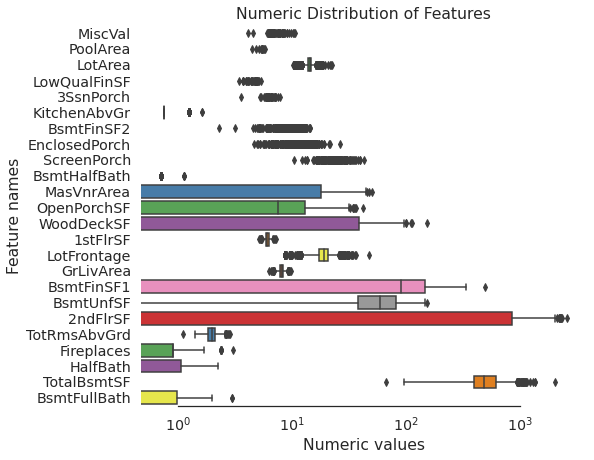

In [45]:
# Let's make sure we handled all the skewed values
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=train[skew_index] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [46]:
skew_features1 = train[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features1[skew_features1 > 5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features1.head(10)

There are 4 numerical features with Skew > 0.5 :


PoolArea         15.592364
3SsnPorch         8.860495
LowQualFinSF      8.491121
MiscVal           5.237027
BsmtHalfBath      3.778671
KitchenAbvGr      3.777556
ScreenPorch       3.151991
BsmtFinSF2        2.577759
EnclosedPorch     2.148620
MasVnrArea        0.977229
dtype: float64

In [47]:
# creating useful time features
train['YearsSinceRemodel'] = train['YrSold'].astype(int) - train['YearRemodAdd'].astype(int)
train['YrBltAndRemod'] = train['YearRemodAdd']-train['YearBuilt']


In [48]:
for i in train[['YearsSinceRemodel','YrBltAndRemod']].columns:
    print(i, train[i].unique())

YearsSinceRemodel [ 5 31  6 36  8 14  2 58 43  0 46 48 40 39  4 44 57  9 10  1 51 19  3 53
 41 24 28 47 56 52 11 60 21 34  7 42 13 27 12 45 16 25 30 33 54 20 37 50
 15 38 17 32 35 22 18 59 29 49 26 55 23 -1 -2]
YrBltAndRemod [  0   1  55   2  19  11  72   7  20  33  49  40  23  30  36  54   5  88
  16   6  76  29  24  35  53  71  67  85 110  86  18  57  47  43  25  62
  14  15  27  26  78  59  38   9  51  83 101  32   3  39  10  52  50   8
  48  79  58  82  17 122  65  34  75  60  42  77  28  22  61  46  89  80
  13  63  90  70  37 100  44   4  81 107  21  64 111  69  31  68  96 108
  56  92 123  94  45  87  41  74  98  12 103 106  93 104  73 121 115  95
  84 112  97 127  -1 109  66 116 105]


In [49]:
pd.set_option('display.max_columns',None)
train.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,YearsSinceRemodel,YrBltAndRemod
0,6,RL,18.133318,14.054263,2,0,4,Lvl,Inside,3,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,19.438231,4,3,PConc,4,3,0,6,143.920047,1,0.0,30.010268,422.114947,GasA,5,Y,SBrkr,5.929136,1026.391549,0.0,8.339939,0.993263,0.000000,2,1.068921,3,0.750955,4,2.262646,8,0.000000,0,Attchd,2003.0,2,2.0,548.0,3,3,2,0.000000,12.071122,0.000000,0.0,0.0,0.0,0,0,None,0.0,2,2008,WD,Normal,5,0
1,1,RL,20.660028,14.347269,2,0,4,Lvl,FR2,3,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,3,3,CBlock,4,3,3,5,181.454701,1,0.0,44.168170,593.327333,GasA,5,Y,SBrkr,6.224032,0.000000,0.0,7.962253,0.000000,0.710938,2,0.000000,3,0.750955,3,1.997107,8,0.903299,3,Attchd,1976.0,2,2.0,460.0,3,3,2,56.101584,0.000000,0.000000,0.0,0.0,0.0,0,0,None,0.0,5,2007,WD,Normal,31,0
2,6,RL,18.656316,14.716277,2,0,3,Lvl,Inside,3,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,17.773262,4,3,PConc,4,3,1,6,110.299851,1,0.0,56.942691,449.676734,GasA,5,Y,SBrkr,5.984244,1041.273148,0.0,8.394288,0.993263,0.000000,2,1.068921,3,0.750955,4,1.997107,8,0.903299,3,Attchd,2001.0,2,2.0,608.0,3,3,2,0.000000,9.894344,0.000000,0.0,0.0,0.0,0,0,None,0.0,9,2008,WD,Normal,6,1
3,7,RL,17.239197,14.335210,2,0,3,Lvl,Corner,3,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,3,3,BrkTil,3,4,0,5,61.728759,1,0.0,64.863766,378.526862,GasA,4,Y,SBrkr,6.017494,905.115976,0.0,8.345041,0.993263,0.000000,1,0.000000,3,0.750955,4,2.137976,8,0.903299,4,Detchd,1998.0,1,3.0,642.0,3,3,2,0.000000,8.960357,16.025062,0.0,0.0,0.0,0,0,None,0.0,2,2006,WD,Abnorml,36,55
4,6,RL,21.300075,15.277957,2,0,3,Lvl,FR2,3,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,25.411668,4,3,PConc,4,3,2,6,136.439665,1,0.0,61.217220,544.803190,GasA,5,Y,SBrkr,6.150533,1273.975831,0.0,8.654709,0.993263,0.000000,2,1.068921,4,0.750955,4,2.374499,8,0.903299,3,Attchd,2000.0,2,3.0,836.0,3,3,2,42.189389,14.259706,0.000000,0.0,0.0,0.0,0,0,None,0.0,12,2008,WD,Normal,8,0


In [50]:
 # converting the entries with/without deck/porch area to 0/1
train['HasWoodDeck'] = (train['WoodDeckSF'] == 0) * 1      
train['HasOpenPorch'] = (train['OpenPorchSF'] == 0) * 1
train['HasEnclosedPorch'] = (train['EnclosedPorch'] == 0) * 1
train['Has3SsnPorch'] = (train['3SsnPorch'] == 0) * 1
train['HasScreenPorch'] = (train['ScreenPorch'] == 0) * 1
train
# creating simple binary columns that indicate if that feature is present
train['haspool'] = train['PoolArea'].apply(lambda x: 1 if x > 0 else 0) 
train['has2ndfloor'] = train['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
train['hasgarage'] = train['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
train['hasbsmt'] = train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
train['hasfireplace'] = train['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# 2* Combinations of existing features

# Overall quality of the house
train["TotalHouseGrade"] = train["OverallQual"] * train["OverallCond"]
# Overall quality of the garage
train["GarageGrade"] = train["GarageQual"] * train["GarageCond"]
# Overall quality of the exterior
train["ExteriorGrade"] = train["ExterQual"] * train["ExterCond"]
train# Overall kitchen score
train["KitchenScore"] = train["KitchenAbvGr"] * train["KitchenQual"]
# Overall fireplace score
train["FireplaceScore"] =train["Fireplaces"] * train["FireplaceQu"]
# Overall garage score
train["GarageScore"] = train["GarageArea"] * train["GarageQual"]
# Overall pool score
train["PoolScore"] = train["PoolArea"] *train["PoolQC"]




# adding up all floor area
train['TotalSF'] =+train["GrLivArea"] +train["TotalBsmtSF"]
# Total area for 1st + 2nd floors
train["TotalFlrsSF"] =train['BsmtFinSF1'] +train['BsmtFinSF2']+ train["1stFlrSF"] + train["2ndFlrSF"]
# Total area for porch
train["AllPorchSF"] = train["OpenPorchSF"] + train["EnclosedPorch"] + \
train["3SsnPorch"] + train["ScreenPorch"]

# Total number of bathrooms
# total bathrooms with more weightage given to full sized
train['Total_Bathrooms'] = (train['FullBath'] + (0.5 * train['HalfBath']) +\
                             train['BsmtFullBath'] + (0.5 * train['BsmtHalfBath']))


# Has masonry veneer or not
train["HasMasVnr"] = train.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, \
                                              "Stone" : 1, "None" : 0})
# House completed before sale or not
train["BoughtOffPlan"] =train.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0,\
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})


In [51]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,YearsSinceRemodel,YrBltAndRemod,HasWoodDeck,HasOpenPorch,HasEnclosedPorch,Has3SsnPorch,HasScreenPorch,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,TotalHouseGrade,GarageGrade,ExteriorGrade,KitchenScore,FireplaceScore,GarageScore,PoolScore,TotalSF,TotalFlrsSF,AllPorchSF,Total_Bathrooms,HasMasVnr,BoughtOffPlan
0,6,RL,18.133318,14.054263,2,0,4,Lvl,Inside,3,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,19.438231,4,3,PConc,4,3,0,6,143.920047,1,0.0,30.010268,422.114947,GasA,5,Y,SBrkr,5.929136,1026.391549,0.0,8.339939,0.993263,0.000000,2,1.068921,3,0.750955,4,2.262646,8,0.000000,0,Attchd,2003.0,2,2.0,548.0,3,3,2,0.000000,12.071122,0.000000,0.0,0.0,0.0,0,0,None,0.0,2,2008,WD,Normal,5,0,1,0,1,1,1,0,1,1,1,0,35,9,12,3.003820,0.000000,1644.0,0.0,430.454885,1176.240731,12.071122,3.527724,1,0
1,1,RL,20.660028,14.347269,2,0,4,Lvl,FR2,3,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,3,3,CBlock,4,3,3,5,181.454701,1,0.0,44.168170,593.327333,GasA,5,Y,SBrkr,6.224032,0.000000,0.0,7.962253,0.000000,0.710938,2,0.000000,3,0.750955,3,1.997107,8,0.903299,3,Attchd,1976.0,2,2.0,460.0,3,3,2,56.101584,0.000000,0.000000,0.0,0.0,0.0,0,0,None,0.0,5,2007,WD,Normal,31,0,0,1,1,1,1,0,0,1,1,1,48,9,9,2.252865,2.709898,1380.0,0.0,601.289586,187.678733,0.000000,2.355469,0,0
2,6,RL,18.656316,14.716277,2,0,3,Lvl,Inside,3,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,17.773262,4,3,PConc,4,3,1,6,110.299851,1,0.0,56.942691,449.676734,GasA,5,Y,SBrkr,5.984244,1041.273148,0.0,8.394288,0.993263,0.000000,2,1.068921,3,0.750955,4,1.997107,8,0.903299,3,Attchd,2001.0,2,2.0,608.0,3,3,2,0.000000,9.894344,0.000000,0.0,0.0,0.0,0,0,None,0.0,9,2008,WD,Normal,6,1,1,0,1,1,1,0,1,1,1,1,35,9,12,3.003820,2.709898,1824.0,0.0,458.071022,1157.557243,9.894344,3.527724,1,0
3,7,RL,17.239197,14.335210,2,0,3,Lvl,Corner,3,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,3,3,BrkTil,3,4,0,5,61.728759,1,0.0,64.863766,378.526862,GasA,4,Y,SBrkr,6.017494,905.115976,0.0,8.345041,0.993263,0.000000,1,0.000000,3,0.750955,4,2.137976,8,0.903299,4,Detchd,1998.0,1,3.0,642.0,3,3,2,0.000000,8.960357,16.025062,0.0,0.0,0.0,0,0,None,0.0,2,2006,WD,Abnorml,36,55,1,0,0,1,1,0,1,1,1,1,35,9,9,3.003820,3.613198,1926.0,0.0,386.871903,972.862230,24.985418,1.993263,0,0
4,6,RL,21.300075,15.277957,2,0,3,Lvl,FR2,3,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,25.411668,4,3,PConc,4,3,2,6,136.439665,1,0.0,61.217220,544.803190,GasA,5,Y,SBrkr,6.150533,1273.975831,0.0,8.654709,0.993263,0.000000,2,1.068921,4,0.750955,4,2.374499,8,0.903299,3,Attchd,2000.0,2,3.0,836.0,3,3,2,42.189389,14.259706,0.000000,0.0,0.0,0.0,0,0,None,0.0,12,2008,WD,Normal,8,0,0,0,1,1,1,0,1,1,1,1,40,9,12,3.003820,2.709898,2508.0,0.0,553.457899,1416.566029,14.259706,3.527724,1,0


In [52]:
categorical_features=train.select_dtypes(include=['object']).columns
numerical_features = train.select_dtypes(exclude = ["object"]).columns
cat_df=train[categorical_features]
num_df=train[numerical_features]

In [53]:
cat_df.head()

,MSZoning,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,Electrical,GarageType,MiscFeature,YrSold,SaleType,SaleCondition
0,RL,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,SBrkr,Attchd,None,2008,WD,Normal
1,RL,Lvl,FR2,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,CBlock,GasA,Y,SBrkr,Attchd,None,2007,WD,Normal
2,RL,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,SBrkr,Attchd,None,2008,WD,Normal
3,RL,Lvl,Corner,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,BrkTil,GasA,Y,SBrkr,Detchd,None,2006,WD,Abnorml
4,RL,Lvl,FR2,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,SBrkr,Attchd,None,2008,WD,Normal


In [54]:
num_df.head()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YearsSinceRemodel,YrBltAndRemod,HasWoodDeck,HasOpenPorch,HasEnclosedPorch,Has3SsnPorch,HasScreenPorch,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,TotalHouseGrade,GarageGrade,ExteriorGrade,KitchenScore,FireplaceScore,GarageScore,PoolScore,TotalSF,TotalFlrsSF,AllPorchSF,Total_Bathrooms,HasMasVnr,BoughtOffPlan
0,6,18.133318,14.054263,2,0,4,3,7,5,2003,2003,19.438231,4,3,4,3,0,6,143.920047,1,0.0,30.010268,422.114947,5,5.929136,1026.391549,0.0,8.339939,0.993263,0.000000,2,1.068921,3,0.750955,4,2.262646,8,0.000000,0,2003.0,2,2.0,548.0,3,3,2,0.000000,12.071122,0.000000,0.0,0.0,0.0,0,0,0.0,2,5,0,1,0,1,1,1,0,1,1,1,0,35,9,12,3.003820,0.000000,1644.0,0.0,430.454885,1176.240731,12.071122,3.527724,1,0
1,1,20.660028,14.347269,2,0,4,3,6,8,1976,1976,0.000000,3,3,4,3,3,5,181.454701,1,0.0,44.168170,593.327333,5,6.224032,0.000000,0.0,7.962253,0.000000,0.710938,2,0.000000,3,0.750955,3,1.997107,8,0.903299,3,1976.0,2,2.0,460.0,3,3,2,56.101584,0.000000,0.000000,0.0,0.0,0.0,0,0,0.0,5,31,0,0,1,1,1,1,0,0,1,1,1,48,9,9,2.252865,2.709898,1380.0,0.0,601.289586,187.678733,0.000000,2.355469,0,0
2,6,18.656316,14.716277,2,0,3,3,7,5,2001,2002,17.773262,4,3,4,3,1,6,110.299851,1,0.0,56.942691,449.676734,5,5.984244,1041.273148,0.0,8.394288,0.993263,0.000000,2,1.068921,3,0.750955,4,1.997107,8,0.903299,3,2001.0,2,2.0,608.0,3,3,2,0.000000,9.894344,0.000000,0.0,0.0,0.0,0,0,0.0,9,6,1,1,0,1,1,1,0,1,1,1,1,35,9,12,3.003820,2.709898,1824.0,0.0,458.071022,1157.557243,9.894344,3.527724,1,0
3,7,17.239197,14.335210,2,0,3,3,7,5,1915,1970,0.000000,3,3,3,4,0,5,61.728759,1,0.0,64.863766,378.526862,4,6.017494,905.115976,0.0,8.345041,0.993263,0.000000,1,0.000000,3,0.750955,4,2.137976,8,0.903299,4,1998.0,1,3.0,642.0,3,3,2,0.000000,8.960357,16.025062,0.0,0.0,0.0,0,0,0.0,2,36,55,1,0,0,1,1,0,1,1,1,1,35,9,9,3.003820,3.613198,1926.0,0.0,386.871903,972.862230,24.985418,1.993263,0,0
4,6,21.300075,15.277957,2,0,3,3,8,5,2000,2000,25.411668,4,3,4,3,2,6,136.439665,1,0.0,61.217220,544.803190,5,6.150533,1273.975831,0.0,8.654709,0.993263,0.000000,2,1.068921,4,0.750955,4,2.374499,8,0.903299,3,2000.0,2,3.0,836.0,3,3,2,42.189389,14.259706,0.000000,0.0,0.0,0.0,0,0,0.0,12,8,0,0,0,1,1,1,0,1,1,1,1,40,9,12,3.003820,2.709898,2508.0,0.0,553.457899,1416.566029,14.259706,3.527724,1,0


In [55]:
cols_poly=['TotalHouseGrade','TotalSF','TotalFlrsSF','AllPorchSF','GrLivArea','ExteriorGrade','GarageCars','Total_Bathrooms','KitchenQual','GarageScore']

In [56]:
from sklearn.preprocessing import PolynomialFeatures
poly=PolynomialFeatures(degree=4)
higher=poly.fit_transform(num_df[cols_poly])
names=poly.get_feature_names(cols_poly)
high=pd.DataFrame(higher,columns=names)

In [57]:
num_df.shape

(2916, 81)

In [58]:
high.reset_index(drop=True, inplace=True)

In [59]:
new_num_df=pd.concat([num_df,high],axis=1)

In [60]:
new_num_df.shape

(2916, 1082)

In [61]:
final_col_names=new_num_df.columns

In [62]:
from sklearn.preprocessing import RobustScaler
robust=RobustScaler()
new_num_df=robust.fit_transform(new_num_df)
new_num_df=pd.DataFrame(new_num_df,columns=final_col_names)



In [63]:
new_num_df.shape

(2916, 1082)

In [64]:
new_num_df.head()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YearsSinceRemodel,YrBltAndRemod,HasWoodDeck,HasOpenPorch,HasEnclosedPorch,Has3SsnPorch,HasScreenPorch,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,TotalHouseGrade,GarageGrade,ExteriorGrade,KitchenScore,FireplaceScore,GarageScore,PoolScore,TotalSF,TotalFlrsSF,AllPorchSF,Total_Bathrooms,HasMasVnr,BoughtOffPlan,1,TotalHouseGrade,TotalSF,TotalFlrsSF,AllPorchSF,GrLivArea,ExteriorGrade,GarageCars,Total_Bathrooms,KitchenQual,GarageScore,TotalHouseGrade^2,TotalHouseGrade TotalSF,TotalHouseGrade TotalFlrsSF,TotalHouseGrade AllPorchSF,TotalHouseGrade GrLivArea,TotalHouseGrade ExteriorGrade,TotalHouseGrade GarageCars,TotalHouseGrade Total_Bathrooms,TotalHouseGrade KitchenQual,TotalHouseGrade GarageScore,TotalSF^2,TotalSF TotalFlrsSF,TotalSF AllPorchSF,TotalSF GrLivArea,TotalSF ExteriorGrade,TotalSF GarageCars,TotalSF Total_Bathrooms,TotalSF KitchenQual,TotalSF GarageScore,TotalFlrsSF^2,TotalFlrsSF AllPorchSF,TotalFlrsSF GrLivArea,TotalFlrsSF ExteriorGrade,TotalFlrsSF GarageCars,TotalFlrsSF Total_Bathrooms,TotalFlrsSF KitchenQual,TotalFlrsSF GarageScore,AllPorchSF^2,AllPorchSF GrLivArea,AllPorchSF ExteriorGrade,AllPorchSF GarageCars,AllPorchSF Total_Bathrooms,AllPorchSF KitchenQual,AllPorchSF GarageScore,GrLivArea^2,GrLivArea ExteriorGrade,GrLivArea GarageCars,GrLivArea Total_Bathrooms,GrLivArea KitchenQual,GrLivArea GarageScore,ExteriorGrade^2,ExteriorGrade GarageCars,ExteriorGrade Total_Bathrooms,ExteriorGrade KitchenQual,ExteriorGrade GarageScore,GarageCars^2,GarageCars Total_Bathrooms,GarageCars KitchenQual,GarageCars GarageScore,Total_Bathrooms^2,Total_Bathrooms KitchenQual,Total_Bathrooms GarageScore,KitchenQual^2,KitchenQual GarageScore,GarageScore^2,TotalHouseGrade^3,TotalHouseGrade^2 TotalSF,TotalHouseGrade^2 TotalFlrsSF,TotalHouseGrade^2 AllPorchSF,TotalHouseGrade^2 GrLivArea,TotalHouseGrade^2 ExteriorGrade,TotalHouseGrade^2 GarageCars,TotalHouseGrade^2 Total_Bathrooms,TotalHouseGrade^2 KitchenQual,TotalHouseGrade^2 GarageScore,TotalHouseGrade TotalSF^2,TotalHouseGrade TotalSF TotalFlrsSF,TotalHouseGrade TotalSF AllPorchSF,TotalHouseGrade TotalSF GrLivArea,TotalHouseGrade TotalSF ExteriorGrade,TotalHouseGrade TotalSF GarageCars,TotalHouseGrade TotalSF Total_Bathrooms,TotalHouseGrade TotalSF KitchenQual,TotalHouseGrade TotalSF GarageScore,TotalHouseGrade TotalFlrsSF^2,TotalHouseGrade TotalFlrsSF AllPorchSF,TotalHouseGrade TotalFlrsSF GrLivArea,TotalHouseGrade TotalFlrsSF ExteriorGrade,TotalHouseGrade TotalFlrsSF GarageCars,TotalHouseGrade TotalFlrsSF Total_Bathrooms,TotalHouseGrade TotalFlrsSF KitchenQual,TotalHouseGrade TotalFlrsSF GarageScore,TotalHouseGrade AllPorchSF^2,TotalHouseGrade AllPorchSF GrLivArea,TotalHouseGrade AllPorchSF ExteriorGrade,TotalHouseGrade AllPorchSF GarageCars,TotalHouseGrade AllPorchSF Total_Bathrooms,TotalHouseGrade AllPorchSF KitchenQual,TotalHouseGrade AllPorchSF GarageScore,TotalHouseGrade GrLivArea^2,TotalHouseGrade GrLivArea ExteriorGrade,TotalHouseGrade GrLivArea GarageCars,TotalHouseGrade GrLivArea Total_Bathrooms,TotalHouseGrade GrLivArea KitchenQual,TotalHouseGrade GrLivArea GarageScore,TotalHouseGrade ExteriorGrade^2,TotalHouseGrade ExteriorGrade GarageCars,TotalHouseGrade ExteriorGrade Total_Bathrooms,TotalHouseGrade ExteriorGrade KitchenQual,TotalHouseGrade ExteriorGrade GarageScore,TotalHouseGrade GarageCars^2,TotalHouseGrade GarageCars Total_Bathrooms,TotalHouseGrade GarageCars KitchenQual,Tota

In [65]:
new_num_df.reset_index(drop=True, inplace=True)

In [66]:
cat_df=pd.get_dummies(cat_df)

In [67]:
cat_df.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,

In [68]:
cat_df.reset_index(drop=True, inplace=True)

In [69]:
full_df=pd.concat([new_num_df,cat_df],axis=1)

In [70]:
full_df.shape

(2916, 1250)

In [71]:
y_train.shape

(1457,)

In [72]:
full_df = full_df.loc[:,~full_df.columns.duplicated()]

In [73]:
full_df.shape

(2916, 1240)

In [74]:
X = full_df.iloc[:len(y_train), :]
X_test = full_df.iloc[len(y_train):, :]
X.shape, y_train.shape, X_test.shape

((1457, 1240), (1457,), (1459, 1240))

In [75]:
# creating validation set
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid=train_test_split(X,y_train,test_size=0.3,random_state=100)

In [76]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(1019, 1240)
(1019,)
(438, 1240)
(438,)


In [77]:
from sklearn.model_selection import KFold,cross_val_score
from sklearn.metrics import r2_score
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score, mean_squared_error
kf = KFold(n_splits=3, random_state=42, shuffle=True)
# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_r2(model, X,y):
    r2 = cross_val_score(model, X, y, scoring="r2", cv=kf,verbose=3,n_jobs=-1)
    return (r2)

In [94]:
# lasso Regressor
alpha=np.linspace(0,0.02,400)
las= LassoCV(alphas=alpha, cv=kf)

In [95]:
las.fit(X_train,y_train)

LassoCV(alphas=array([0.00000000e+00, 5.01253133e-05, 1.00250627e-04, 1.50375940e-04,
       2.00501253e-04, 2.50626566e-04, 3.00751880e-04, 3.50877193e-04,
       4.01002506e-04, 4.51127820e-04, 5.01253133e-04, 5.51378446e-04,
       6.01503759e-04, 6.51629073e-04, 7.01754386e-04, 7.51879699e-04,
       8.02005013e-04, 8.52130326e-04, 9.02255639e-04, 9.52380952e-04,
       1.00250627e-03, 1.05263158e-0...
       1.90476190e-02, 1.90977444e-02, 1.91478697e-02, 1.91979950e-02,
       1.92481203e-02, 1.92982456e-02, 1.93483709e-02, 1.93984962e-02,
       1.94486216e-02, 1.94987469e-02, 1.95488722e-02, 1.95989975e-02,
       1.96491228e-02, 1.96992481e-02, 1.97493734e-02, 1.97994987e-02,
       1.98496241e-02, 1.98997494e-02, 1.99498747e-02, 2.00000000e-02]),
        cv=KFold(n_splits=3, random_state=42, shuffle=True))

In [97]:
las.alpha_

0.0009523809523809524

Lasso picked 112 features and eliminated the other 1128 features


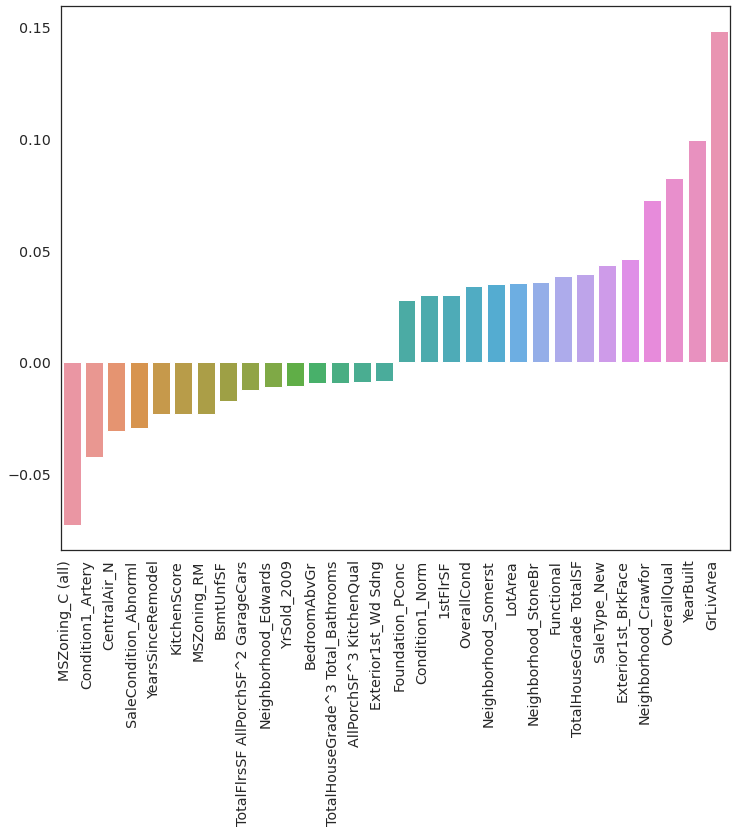

In [98]:
coefs = pd.Series(las.coef_, index = X.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(15),
                     coefs.sort_values().tail(15)])
# imp_coefs.plot(kind = "barh");
# plt.title("Coefficients in the Ridge Model")
# plt.yticks(rotation=0)

# plt.figure(figsize=(25,20))
# plt.show()
plt.figure(figsize=(12,10))

bar=sns.barplot(imp_coefs.index,imp_coefs.values)
bar.set_xticklabels(bar.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')
plt.show()

In [99]:
y_train_pred=las.predict(X_train)

In [100]:
print('r2 for train data is {} and RMSE is {}'.format(r2_score(y_train,y_train_pred),np.sqrt(mean_squared_error(y_train,y_train_pred))))

r2 for train data is 0.9478897618949147 and RMSE is 0.09026502960066429


In [101]:
y_valid_pred=las.predict(X_valid)

In [102]:
print('r2 for test data is {} and RMSE is {}'.format(r2_score(y_valid,y_valid_pred),np.sqrt(mean_squared_error(y_valid,y_valid_pred))))

r2 for test data is 0.9022705035634574 and RMSE is 0.12785217066266802


In [103]:
submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
submission.shape

(1459, 2)

In [104]:
submission.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [106]:
y_test_pred=np.expm1(las.predict(X_test))

In [108]:
y_test_pred[:5]

array([116704.42834635, 158120.78475111, 183995.90319495, 201281.40908811,
       186237.85919465])

In [110]:
submission.iloc[:,1]=y_test_pred

In [ ]:
submission.to_csv('submission_lasso.csv',index=False)